In [1]:
import einops
import matplotlib.pyplot as plt
import torch

import plenoptic as po

%load_ext autoreload
%autoreload

# We need to download some additional images for this notebook. In order to do so,
# we use an optional dependency, pooch. If the following raises an ImportError or
# ModuleNotFoundError
# then install pooch in your plenoptic environment and restart your kernel.
from plenoptic.data.fetch import fetch_data

DATA_PATH = fetch_data("portilla_simoncelli_images.tar.gz")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

# set seed for reproducibility
po.tools.set_seed(1)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# These variables control how long metamer synthesis runs for. The values present
# here will result in completed synthesis, but you may want to decrease these numbers
# if you're on a machine with limited resources.
short_synth_max_iter = 1000
long_synth_max_iter = 3000
longest_synth_max_iter = 4000

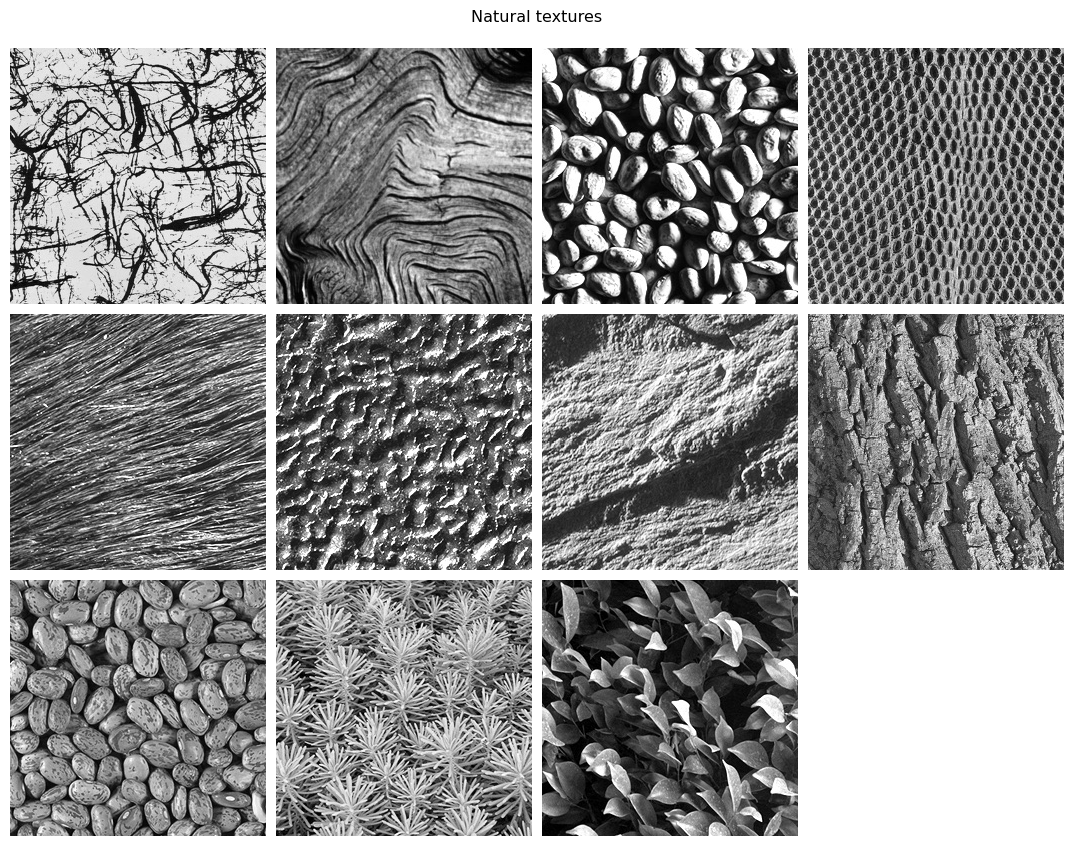

In [3]:
# Load and display a set of visual textures


def display_images(im_files, title=None):
    images = po.tools.load_images(im_files)
    fig = po.imshow(images, col_wrap=4, title=None)
    if title is not None:
        fig.suptitle(title, y=1.05)


natural = [
    "3a",
    "6a",
    "8a",
    "14b",
    "15c",
    "15d",
    "15e",
    "15f",
    "16c",
    "16b",
    "16a",
]
artificial = ["4a", "4b", "14a", "16e", "14e", "14c", "5a"]
hand_drawn = ["5b", "13a", "13b", "13c", "13d"]

im_files = [DATA_PATH / f"fig{num}.jpg" for num in natural]
display_images(im_files, "Natural textures")

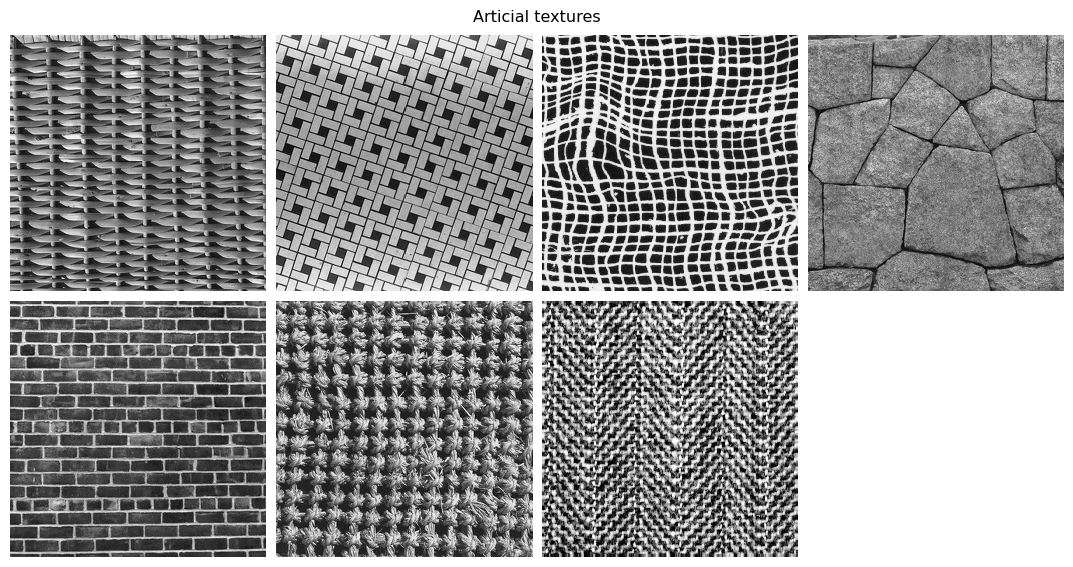

In [4]:
im_files = [DATA_PATH / f"fig{num}.jpg" for num in artificial]
display_images(im_files, "Articial textures")

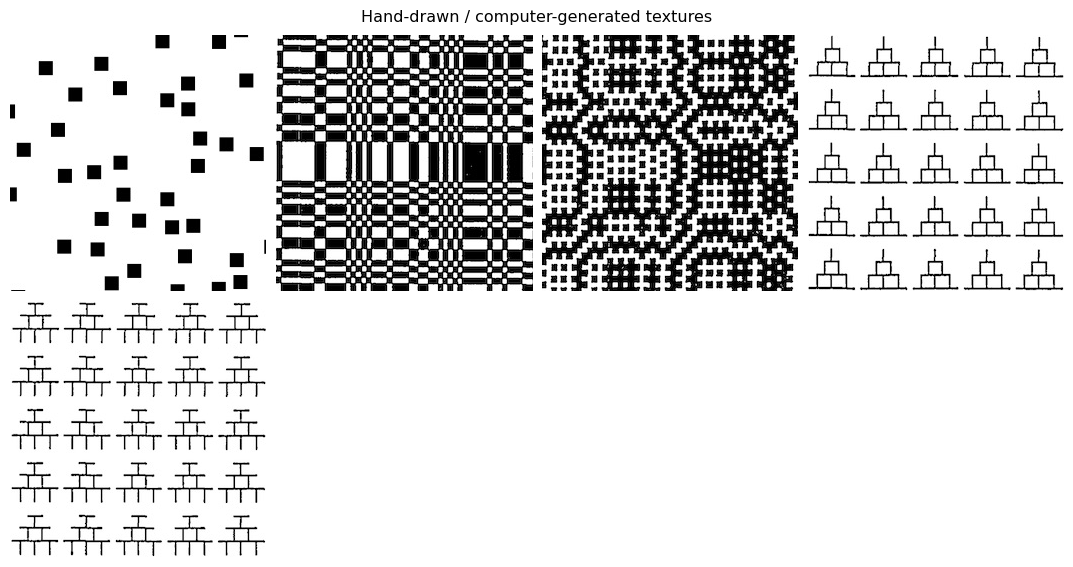

In [5]:
im_files = [DATA_PATH / f"fig{num}.jpg" for num in hand_drawn]
display_images(im_files, "Hand-drawn / computer-generated textures")

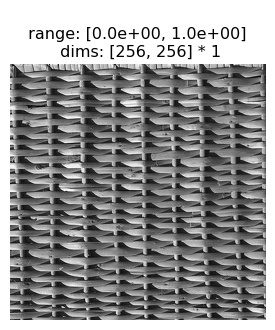

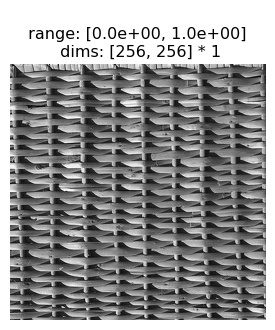

In [6]:
img = po.tools.load_images(DATA_PATH / "fig4a.jpg")
po.imshow(img)

In [7]:
n = img.shape[-1]
model = po.simul.PortillaSimoncelli([n, n])
stats = model(img)
print(stats)

tensor([[[ 0.4350,  0.0407,  0.1622,  ..., -0.0078, -0.2282,  0.0023]]])


In [8]:
met = po.synth.Metamer(img, model)
met.synthesize(store_progress=True, max_iter=10)

100%|██████████| 10/10 [00:01<00:00,  9.86it/s, loss=4.5063e-02, learning_rate=0.01, gradient_norm=1.6559e-02, pixel_change_norm=1.2805e+00]


(<Figure size 2131.2x360 with 11 Axes>,
 {'display_metamer': 0,
  'plot_loss': 1,
  'plot_representation_error': [3, 4, 5, 6, 7, 8, 9, 10, 2],
  'misc': []})

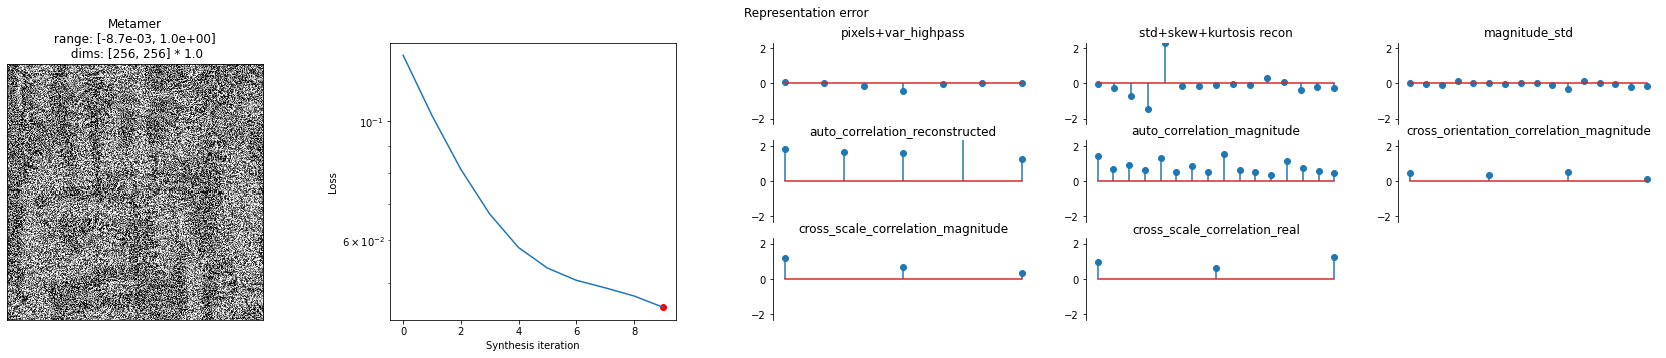

In [9]:
# representation_error plot has three subplots, so we increase its relative width
po.synth.metamer.plot_synthesis_status(
    met, width_ratios={"plot_representation_error": 3.1}
)

In [10]:
# send image and PS model to GPU, if available. then im_init and Metamer will also
# use GPU
img = img.to(DEVICE)
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
im_init = (torch.rand_like(img) - 0.5) * 0.1 + img.mean()
met = po.synth.MetamerCTF(
    img,
    model,
    loss_function=po.tools.optim.l2_norm,
    coarse_to_fine="together",
)
met.setup(im_init)
o = met.synthesize(
    max_iter=short_synth_max_iter,
    store_progress=True,
    # setting change_scale_criterion=None means that we change scales every
    # ctf_iters_to_check, see the metamer notebook for details.
    change_scale_criterion=None,
    ctf_iters_to_check=7,
)

/home/mbernard/Simoncelli/env/lib/python3.10/site-packages/plenoptic/tools/validate.py:320: UserWarning: Validating whether model can work with coarse-to-fine synthesis -- this can take a while!
  warnings.warn(
 73%|███████▎  | 728/1000 [01:24<00:30,  8.89it/s, loss=8.2651e-02, learning_rate=0.01, gradient_norm=8.2933e-01, pixel_change_norm=1.5895e-01, current_scale=all, current_scale_loss=8.2651e-02]            /home/mbernard/Simoncelli/env/lib/python3.10/site-packages/plenoptic/synthesize/metamer.py:932: UserWarning: Loss has converged, stopping synthesis
  warnings.warn("Loss has converged, stopping synthesis")
 73%|███████▎  | 728/1000 [01:24<00:31,  8.66it/s, loss=8.2651e-02, learning_rate=0.01, gradient_norm=8.2933e-01, pixel_change_norm=1.5895e-01, current_scale=all, current_scale_loss=8.2651e-02]


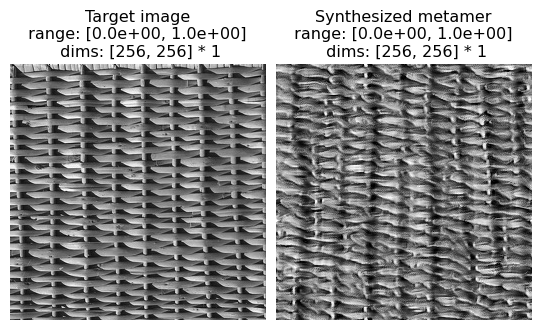

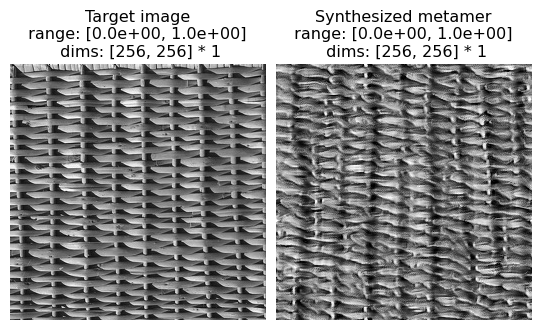

In [11]:
po.imshow(
    [met.image, met.metamer],
    title=["Target image", "Synthesized metamer"],
    vrange="auto1",
)

(<Figure size 2131.2x360 with 11 Axes>,
 {'display_metamer': 0,
  'plot_loss': 1,
  'plot_representation_error': [3, 4, 5, 6, 7, 8, 9, 10, 2],
  'misc': []})

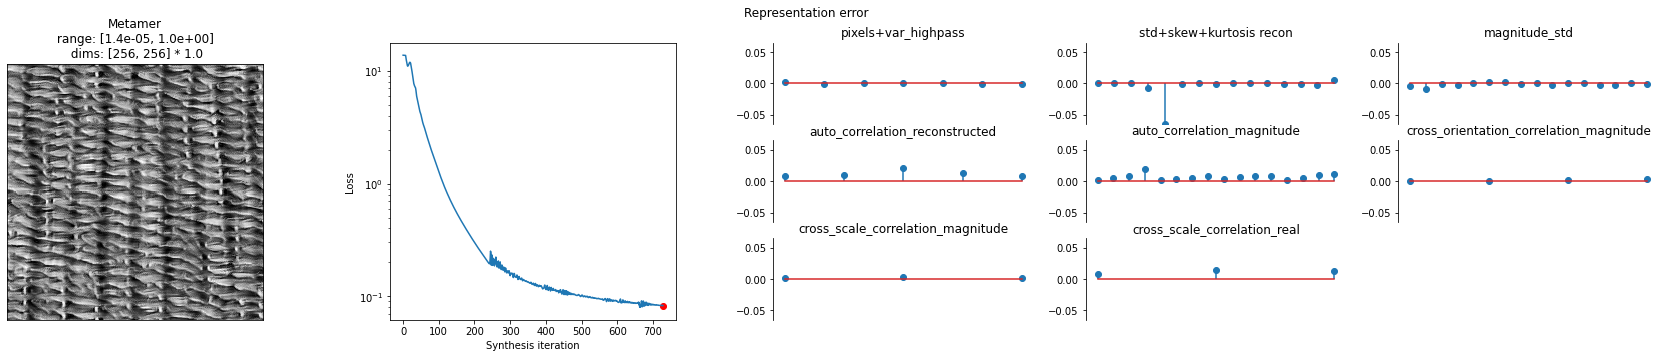

In [12]:
po.synth.metamer.plot_synthesis_status(
    met, width_ratios={"plot_representation_error": 3.1}
)